In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [2]:
pathIn = "lane_input/"
pathOut = "lane_output/"

In [3]:
def video_to_frames(input_loc, output_loc):

    cap = cv2.VideoCapture(input_loc)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        cv2.imwrite(output_loc + "%04d" % count + '.jpg', frame)
        count = count + 1

        if (count > (video_length-1)):
            cap.release()
            break

def frames_to_video(input_loc,output_loc):
    frame_array = []
    files = os.listdir(input_loc)  
    files.sort()

    for i,file_name in enumerate(files):
        img = cv2.imread(input_loc+file_name)
        height, width, layers = img.shape
        size = (width,height)
        frame_array.append(img)

    out = cv2.VideoWriter(output_loc,cv2.VideoWriter_fourcc(*'XVID'), 14.0, size)

    for j in range(len(frame_array)):
        out.write(frame_array[j])
    out.release()

def load_input_frames(path):
    img = []
    images = os.listdir(path)
    images.sort()

    for i, image_name in enumerate(images):
        image = cv2.imread(path+image_name,1)
        img.append(image)
    
    return img

In [20]:
def canny_edge_detector(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny  

def ROI_mask(image):
    height, width = image.shape
    polygons = np.array([ [(0, height), (0, round(height*0.65)), (round(width/2), round(height*0.65)), (width, round(height*0.65)), (width, height)] ]) 
    mask = np.zeros_like(image) 
    cv2.fillPoly(mask, polygons, 255) 
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def get_coordinates (image, params):
     
    slope, intercept = params 
    y1 = image.shape[0]     
    y2 = int(y1 * (0.625)) 
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)

    if (x1 < 0):
        x1 = int(0)
        y1 = int(intercept)
    elif (x1 > image.shape[1]):
        x1 = image.shape[1]
        y1 = int(( slope * image.shape[1] ) + intercept )
    
    return np.array([x1, y1, x2, y2])

# def avg_lines(image, lines): 
#     left = [] 
#     right = [] 
#     middle = []
    
#     for line in lines: 
#         x1, y1, x2, y2 = line.reshape(4)  
#         slope, y_intercept = np.polyfit((x1, x2), (y1, y2), 1)

#         if slope > 0:    
#             if 0.55 > slope > 0.45:
#                 middle.append((slope, y_intercept)) 
#             else: 
#                 right.append((slope, y_intercept)) 
#         else:    
#             if -0.55 < slope < -0.45:
#                 middle.append((slope, y_intercept)) 
#             else: 
#                 left.append((slope, y_intercept)) 
    
#     left_avg = np.average(left, axis = 0) 
#     right_avg = np.average(right, axis = 0) 
#     middle_avg = np.average(middle, axis = 0)
#     left_line = get_coordinates(image, left_avg) 
#     right_line = get_coordinates(image, right_avg)
#     middle_line = get_coordinates(image, middle_avg)
    
#     return np.array([left_line, middle_line, right_line])

def draw_lines(inputimage, lines, thickness): 

    image = inputimage.copy()

    color=[0, 0, 255]
    if lines is not None: 
        for params in lines:
            x1, y1, x2, y2 = get_coordinates(image, params)
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)

    return image

# def lane(lines):
#     slope = []
#     for line in lines:
#         x1, y1, x2, y2 = line.reshape(4)
#         params = np.polyfit((x1, x2), (y1, y2), 1)  
#         slope.append(params[0])

#     if slope[0]*slope[1]>0:
#         return "Car in Right Lane"
#     elif slope[2]*slope[1]>0:
#         return "Car in Left Lane"
#     else:
#         return "Car not on any Lane"
    
def lowest_coordinate(points):
    return points[0]

def arrange(inputimage, lines):

    temp = []

    for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            params = np.polyfit((x1, x2), (y1, y2), 1)  
            a = get_coordinates(inputimage, params)
            if (abs(params[0]) > 0.001):
                temp.append(a)        

    temp.sort(key = lowest_coordinate)

    return temp

def lane_groups(lines):
    params = []
    count = 0
    angle_temp = 0
    intercept_temp = 0
    
    for line in lines: 
        x1, y1, x2, y2 = line.reshape(4)  
        slope, y_intercept = np.polyfit((x1, x2), (y1, y2), 1)
        angle = math.degrees(math.atan(slope))

        if (count == 0 or (abs(angle - angle_temp) > 5)):
            angle_temp = angle
            intercept_temp = y_intercept
            params.append((math.tan(math.radians(angle_temp)) , intercept_temp))
            count = 1

        else:
            angle_temp =  ((angle_temp * count) + angle)/(count + 1)
            intercept_temp = ((intercept_temp * count) + y_intercept)/(count + 1)
            count = count + 1

    return np.array(params)

def laneFindingPipeLine(inputimage):
    canny_edges = canny_edge_detector(inputimage)
    cropped_image = ROI_mask(canny_edges)
    lines = cv2.HoughLinesP(cropped_image, rho=2, theta=np.pi/180, threshold=100, lines=np.array([]), minLineLength=10, maxLineGap=10 )
    lines = arrange(inputimage, lines)
    lines = lane_groups(lines)
    lines = np.reshape(lines, (len(lines), 2))
    image = draw_lines(inputimage, lines, 5)
    # averaged_lines = avg_lines (inputimage, lines)           
    # combined_image = draw_lines(inputimage, averaged_lines, 5) 
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # cv2.putText(combined_image,lane(averaged_lines),(500,100), font, 1, (255,0,0), 2, cv2.LINE_AA)
    return image

In [5]:
def detect_lane_in_video():
    video_to_frames('input.mp4', pathIn)
    images = load_input_frames(pathIn)

    for i in range (0, len(images)-1):
        frame = laneFindingPipeLine(images[i])
        cv2.imwrite(pathOut+"%04d" % i+'.png', frame)
 
    frames_to_video(pathOut, 'output.mp4')

In [16]:
detect_lane_in_video()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


## Testing

In [7]:
video_to_frames('input.mp4', pathIn)

In [11]:
images = load_input_frames(pathIn)

In [167]:
inputimage = images[100]
canny =  canny_edge_detector(inputimage)
cropped_image = ROI_mask(canny)
lines = cv2.HoughLinesP(cropped_image, rho=2, theta=np.pi/180, threshold=100, lines=np.array([]), minLineLength=10, maxLineGap=10 )

In [ ]:
lines = arrange(inputimage, lines)
lines = lane_groups(lines)
print(lines)
lines = np.reshape(lines, (len(lines), 2))
image = draw_lines(inputimage, lines, 5)

[[-1.23036649e-01  3.47000000e+02]
 [-6.25000000e-01  5.35625000e+02]
 [ 5.76923077e-01  7.84615385e+01]
 [ 2.70562771e-01  1.93939394e+02]
 [ 1.49668840e-15  3.29000000e+02]
 [ 2.79017857e-01  1.86718750e+02]]


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt2'. Sequence item with index 0 has a wrong type


[[-1.23036649e-01  3.47000000e+02]
 [-6.25000000e-01  5.35625000e+02]
 [ 5.76923077e-01  7.84615385e+01]
 [ 2.70562771e-01  1.93939394e+02]]


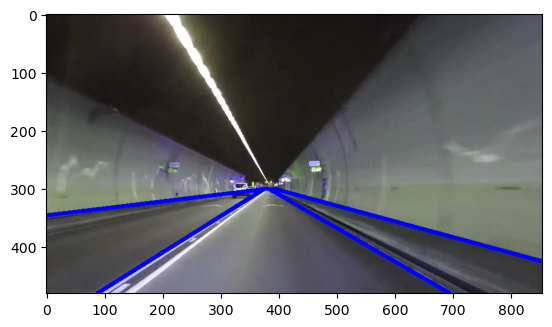

In [152]:
lines = np.reshape(lines, (len(lines), 2))
image = draw_lines(inputimage, lines, 5)
    
plt.imshow(image)

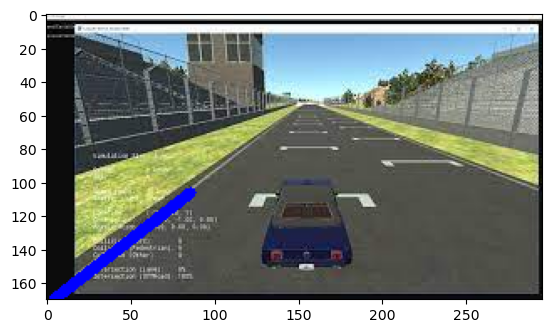

In [21]:
img = cv2.imread('carla.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
check = laneFindingPipeLine(img)
plt.imshow(check)